In [1]:
# The gp_sfh.py file contains a simple GP framework that we'll be using
from gp_sfh import *
from gp_sfh_kernels import *

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

/home/iyer/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# fiducial model:

psd_params = [1.0, 500/1e3, 150/1e3, 0.1, 10/1e3]

# and variations 

psd_var_sigma = 10**np.linspace(-0.5,0.5,10)
psd_var_sigma_gmc = 10**np.linspace(-2.0,0.0,10)
psd_var_tau_eq = 10**np.linspace(1.0,4.0,10)
psd_var_tau_in = 10**np.linspace(1.0,3.0,10)
psd_var_tau_gmc = 10**np.linspace(0.0,2.0,10)

# compare fiducial model to parameter space midpoint
psd_var_sigma[5], psd_var_sigma_gmc[5], psd_var_tau_in[5], psd_var_tau_eq[5], psd_var_tau_gmc[5]

(1.1364636663857248,
 0.1291549665014884,
 129.1549665014884,
 464.15888336127773,
 12.91549665014884)

In [4]:
def analyze_model_deviations(varparam, varlabel, varindex, nsamp = 1000, tarr_res = 1000, zval = 1.0, random_seed = 42):

    cases = []

    for i, param in enumerate(varparam):

        case_params = psd_params.copy()
        case_params[varindex] = param

        case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
        case1.get_tarr(n_tarr = tarr_res)
        #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
        case1.get_basesfh(sfhtype='const')
        case1.kernel = extended_regulator_model_kernel_paramlist


        case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                            force_cov=True, kernel_params = case_params)

        case1.get_spec(nsamp = nsamp)
        case1.calc_spectral_features(massnorm = True)

        cases.append(deepcopy(case1))

    #------------------------------------------------------------------    

    dn4k_mean, dn4k_16, dn4k_84 = [], [], []
    ha_mean, ha_16, ha_84 = [], [], []
    hd_mean, hd_16, hd_84 = [], [], []
    mstar_mean, mstar_16, mstar_84 = [], [], []
    sfr_mean, sfr_16, sfr_84 = [], [], []

    for i, param in enumerate(psd_var_tau_eq):

        dn4k_mean.append(np.mean(cases[i].dn4000_vals))
        dn4k_16.append(np.percentile(cases[i].dn4000_vals,16))    
        dn4k_84.append(np.percentile(cases[i].dn4000_vals,84))    

        tempha = np.array(np.log10(cases[i].ha_lums).copy())
        ha_mean.append(np.mean(tempha))
        ha_16.append(np.percentile(tempha,16))    
        ha_84.append(np.percentile(tempha,84))    

        temphd = np.array(cases[i].hdelta_ews.copy())
        hd_mean.append(np.mean(temphd))
        hd_16.append(np.percentile(temphd,16))    
        hd_84.append(np.percentile(temphd,84))    

        mstar_mean.append(np.mean(np.log10(cases[i].mstar)))
        mstar_16.append(np.percentile(np.log10(cases[i].mstar),16))    
        mstar_84.append(np.percentile(np.log10(cases[i].mstar),84))    

        sfr_mean.append(np.mean(np.array(cases[i].samples)[0:,0]))
        sfr_16.append(np.percentile(np.array(cases[i].samples)[0:,0],16))    
        sfr_84.append(np.percentile(np.array(cases[i].samples)[0:,0],84))    

    #------------------------------------------------------------------

    fig, ax = plt.subplots(1,5,figsize=(21,4))

    plt.subplot(1,5,1)
    plt.plot(varparam, mstar_mean,'-',lw=3)
    plt.fill_between(varparam, mstar_16, mstar_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log Stellar Mass [M$_\odot$]')

    plt.subplot(1,5,2)
    plt.plot(varparam, sfr_mean,'-',lw=3)
    plt.fill_between(varparam, sfr_16, sfr_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log SFR [M$_\odot$/yr]')

    plt.subplot(1,5,3)
    plt.plot(varparam, ha_mean,'-',lw=3)
    plt.fill_between(varparam, ha_16, ha_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'log H$\alpha$ [L$_\odot$]')

    plt.subplot(1,5,4)
    plt.plot(varparam, hd_mean,'-',lw=3)
    plt.fill_between(varparam, hd_16, hd_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'H$\delta_{\rm EW}$ [$\AA$]')

    plt.subplot(1,5,5)
    plt.plot(varparam, dn4k_mean,'-',lw=3)
    plt.fill_between(varparam, dn4k_16, dn4k_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('D$_n$(4000)')
    #plt.axvline(psd_params[1],color='k',alpha=0.7, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return cases

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 243.26it/s]


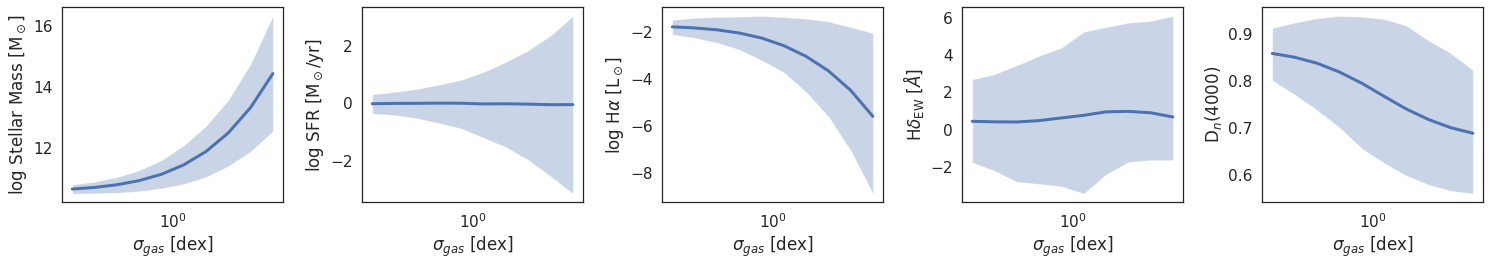

In [5]:
cases_sigma = analyze_model_deviations(varparam = psd_var_sigma, 
                                           varlabel = r'$\sigma_{gas}$ [dex]', 
                                           varindex = 0)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 252.41it/s]


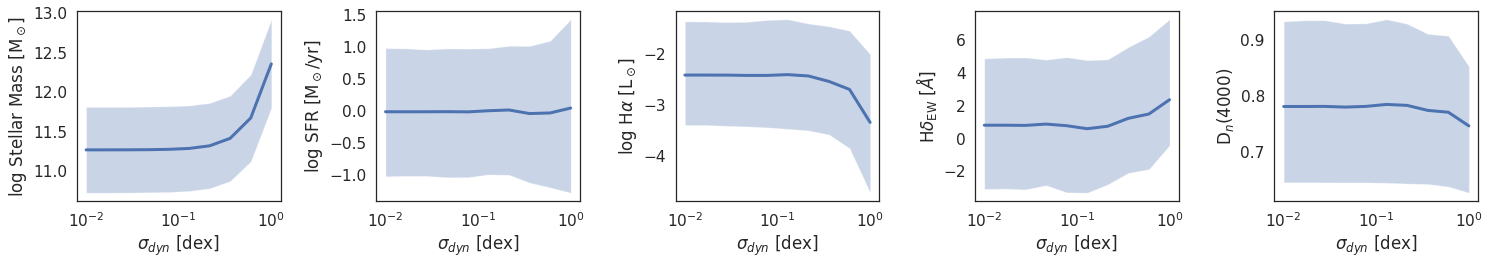

In [6]:
cases_sigma_gmc = analyze_model_deviations(varparam = psd_var_sigma_gmc, 
                                           varlabel = r'$\sigma_{dyn}$ [dex]', 
                                           varindex = 3)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 253.69it/s]


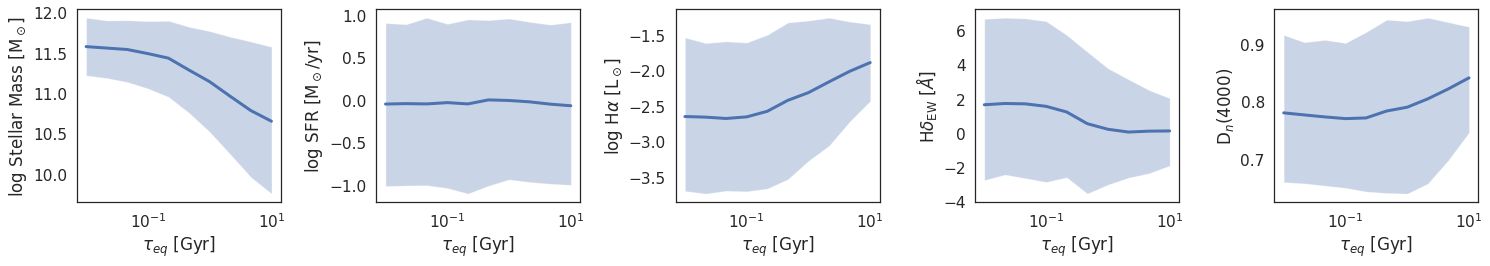

In [7]:
cases_tau_eq = analyze_model_deviations(varparam = psd_var_tau_eq/1e3, 
                                           varlabel = r'$\tau_{eq}$ [Gyr]', 
                                           varindex = 1)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 253.46it/s]


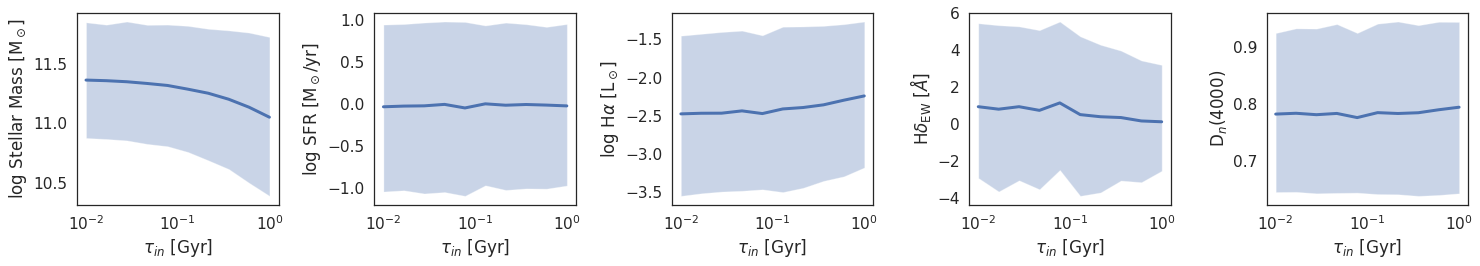

In [8]:
cases_tau_in = analyze_model_deviations(varparam = psd_var_tau_in/1e3, 
                                           varlabel = r'$\tau_{in}$ [Gyr]', 
                                           varindex = 2)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 256.90it/s]


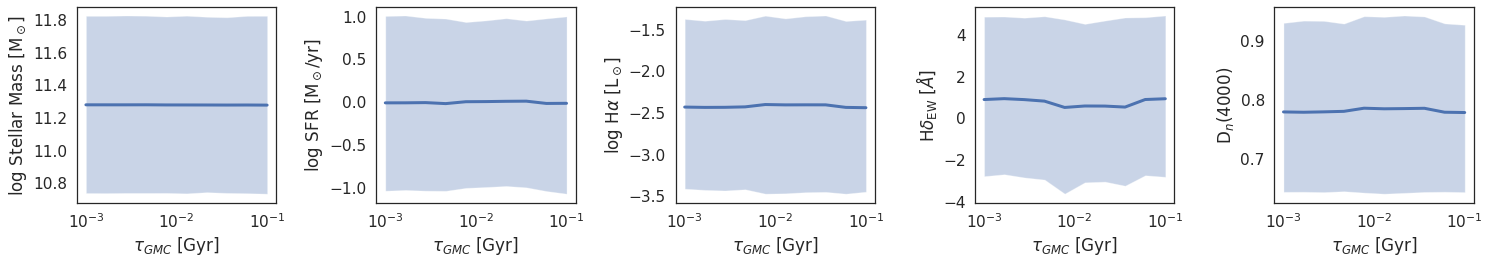

In [9]:
cases_tau_gmc = analyze_model_deviations(varparam = psd_var_tau_gmc/1e3, 
                                           varlabel = r'$\tau_{GMC}$ [Gyr]', 
                                           varindex = 4)

# change plots if needed

In [ ]:
def analyze_model_deviations(cases, varparam, varlabel, varindex, nsamp = 1000, tarr_res = 1000, zval = 1.0, random_seed = 42):

    #------------------------------------------------------------------    

    dn4k_mean, dn4k_16, dn4k_84 = [], [], []
    ha_mean, ha_16, ha_84 = [], [], []
    hd_mean, hd_16, hd_84 = [], [], []
    mstar_mean, mstar_16, mstar_84 = [], [], []
    sfr_mean, sfr_16, sfr_84 = [], [], []

    for i, param in enumerate(psd_var_tau_eq):

        dn4k_mean.append(np.mean(cases[i].dn4000_vals))
        dn4k_16.append(np.percentile(cases[i].dn4000_vals,16))    
        dn4k_84.append(np.percentile(cases[i].dn4000_vals,84))    

        tempha = np.array(np.log10(cases[i].ha_lums).copy())
        ha_mean.append(np.mean(tempha))
        ha_16.append(np.percentile(tempha,16))    
        ha_84.append(np.percentile(tempha,84))    

        temphd = np.array(cases[i].hdelta_ews.copy())
        hd_mean.append(np.mean(temphd))
        hd_16.append(np.percentile(temphd,16))    
        hd_84.append(np.percentile(temphd,84))    

        mstar_mean.append(np.mean(np.log10(cases[i].mstar)))
        mstar_16.append(np.percentile(np.log10(cases[i].mstar),16))    
        mstar_84.append(np.percentile(np.log10(cases[i].mstar),84))    

        sfr_mean.append(np.mean(np.array(cases[i].samples)[0:,0]))
        sfr_16.append(np.percentile(np.array(cases[i].samples)[0:,0],16))    
        sfr_84.append(np.percentile(np.array(cases[i].samples)[0:,0],84))    

    #------------------------------------------------------------------

    fig, ax = plt.subplots(1,5,figsize=(21,4))

    plt.subplot(1,5,1)
    plt.plot(varparam, mstar_mean,'-',lw=3)
    plt.fill_between(varparam, mstar_16, mstar_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log Stellar Mass')

    plt.subplot(1,5,2)
    plt.plot(varparam, sfr_mean,'-',lw=3)
    plt.fill_between(varparam, sfr_16, sfr_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log SFR')

    plt.subplot(1,5,3)
    plt.plot(varparam, ha_mean,'-',lw=3)
    plt.fill_between(varparam, ha_16, ha_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'log H$\alpha$')

    plt.subplot(1,5,4)
    plt.plot(varparam, hd_mean,'-',lw=3)
    plt.fill_between(varparam, hd_16, hd_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'H$\delta_{\rm EW}$')

    plt.subplot(1,5,5)
    plt.plot(varparam, dn4k_mean,'-',lw=3)
    plt.fill_between(varparam, dn4k_16, dn4k_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('D$_n$(4000)')
    #plt.axvline(psd_params[1],color='k',alpha=0.7, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return cases